In [0]:
import os
import itertools
import codecs
import re
import datetime
import editdistance
import numpy as np
import pylab
import random
from itertools import cycle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from imageio import imread, imwrite
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive

K.set_image_data_format('channels_last')

In [4]:
images = []
labels = []
numbers = []
labels_dict = {}
local = False
if local:
  folder = 'out/'
else:
  drive.mount('/content/gdrive')
  folder = '/content/gdrive/My Drive/University/tfg/data/'

with open(folder + "labels.txt") as labelsfile: 
  for line in labelsfile:
    number, label = line.split(": ")
    labels_dict[number] = label.strip()

for filename in os.listdir(folder + "boxes"):
  if not "png" in filename: continue
  # images.append(imread(folder + filename, pilmode='F') / 255)
  images.append(Image.open(folder + "boxes/" + filename).convert('L'))
  number = filename.split(".")[0]
  numbers.append(number)
  labels.append(labels_dict[number])


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
i = 350
len(images)

399

351: 48_2: (q10,1)=(q7,X,R)


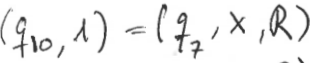

In [6]:
i += 1
print(i, numbers[i], labels[i], sep=": ")
images[i]

In [7]:
print(labels[:5])
print(f"Max label length is {len(max(labels, key=len))}.")

['d(q0,1)=(q1,X,R)', 'd(q1,1)=(q1,1,R)', 'd(q1,0)=(q2,0,R)', 'd(q2,1)=(q3,Y,R)', 'd(q3,B)=(q11,B,L)']
Max label length is 19.


In [8]:
# Get average height and width of images
heights, widths = 0,0
for image in images:
  heights += image.height
  widths += image.width
height, width = heights // len(images), widths // len(images)
height, width

(57, 330)

In [0]:
# Resize images
height, width = 30, 170
res_images = []
for image in images:
  res_images.append(image.resize((width, height), Image.ANTIALIAS))

In [10]:
# View some:
res_images[random.randint(0,len(images)-1)]

In [11]:
# Construct the alphabet
alphabet = set()
for label in labels:
  for char in label:
    alphabet.add(char)
char_to_ix = dict()
ix_to_char = dict()
for ix,char in enumerate(sorted(alphabet)):
  char_to_ix[char] = ix
  ix_to_char[ix] = char
print(*sorted(alphabet))

( ) , 0 1 2 3 4 5 6 7 8 9 = B C F L R X Y Z d q


In [0]:
# Data Parameters 
img_h = height
img_w = width
input_shape = (img_w, img_h, 1)
max_string_len = max([len(label) for label in labels]) + 2

# Network parameters
conv_filters = 64
kernel_size = (3,3)
pool_size = 2
time_dense_size = 64
rnn_size = 256
ctc_cut = 2
ctc_input_length = (img_w // (pool_size ** 3)) - ctc_cut
ctc_input_length = np.expand_dims(np.array([ctc_input_length] * len(images)), 1)
output_size = len(alphabet) + 1
act = 'relu'

In [13]:
# A tensor where all values are the same, is required by ctc loss
ctc_input_length.shape

(399, 1)

In [0]:
# Need to transpose all images
t_images = []
for image in res_images:
    t_images.append(np.expand_dims(np.array(image).T, 2))
t_images = np.array(t_images)

In [0]:
# Need to create an array of label lengths
ctc_label_length = []
for label in labels:
    ctc_label_length.append(len(label))
ctc_label_length = np.expand_dims(np.array(ctc_label_length), 1)

In [0]:
# Need to encode the labels
e_labels = np.full([len(images), max_string_len], len(alphabet))
for i,label in enumerate(labels):
    enc = []
    for char in label:
        enc.append(char_to_ix[char])
        e_labels[i][:len(enc)] = enc

In [0]:
# Shuffle data
# t_images, e_labels, ctc_label_length = shuffle(t_images, e_labels, ctc_label_length)

In [0]:
def label_to_text(ixes):
    ret = []
    for c in ixes:
        if c == len(alphabet) or c == -1:  # CTC Blank
            ret.append("")
        else:
            ret.append(ix_to_char[c])
    return "".join(ret)

In [0]:
# Shuffle and train test split
t_images_train, t_images_test, e_labels_train, e_labels_test, ctc_label_length_train, ctc_label_length_test = train_test_split(t_images, e_labels, ctc_label_length, test_size=10, random_state=99)

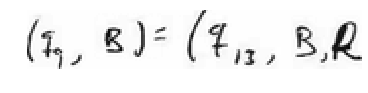

The label is:  (q9,B)=(q13,B,R
Should match:  [15] 15


In [20]:
# Explore the data, check that everything is correct
i = random.randint(0, len(t_images_train)-1)
plt.imshow(np.squeeze(t_images_train[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(e_labels_train[i]))
print("Should match: ", ctc_label_length_train[i], len(label_to_text(e_labels_train[i])))

In [0]:
# The loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, ctc_cut:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [22]:
# Define the model
input_data = Input(name='input', shape=input_shape, dtype='float32')
conv1 = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
conv1 = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(conv1)
conv1 = Dropout(0.2)(conv1)
conv2 = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(conv1)
conv2 = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(conv2)
conv2 = Dropout(0.2)(conv2)
conv3 = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv3')(conv2)
conv3 = MaxPooling2D(pool_size=(pool_size, pool_size), name='max3')(conv3)
conv3 = Dropout(0.2)(conv3)
conv_to_rnn_dims = (img_w // (pool_size ** 3),
                    (img_h // (pool_size ** 3)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(conv3)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
             go_backwards=True, kernel_initializer='he_normal',
             name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size//2, return_sequences=True,
           kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size//2, return_sequences=True, go_backwards=True,
            kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(output_size, kernel_initializer='he_normal',
              name='dense2')(
    concatenate([gru_2, gru_2b])
#       gru1_merged
)

y_pred = Activation('softmax', name='softmax')(inner)
output_labels = Input(name='the_labels',
               shape=[max_string_len], dtype='float32')
input_lengths = Input(name='input_length', shape=[1], dtype='int64')
label_lengths = Input(name='label_length', shape=[1], dtype='int64')

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(
    ctc_lambda_func, output_shape=(1,),
    name='ctc')([y_pred, output_labels, input_lengths, label_lengths])
model = Model(inputs=[input_data, output_labels, input_lengths, label_lengths],
                  outputs=loss_out)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 170, 30, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 170, 30, 64)  640         input[0][0]                      
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 85, 15, 64)   0           conv1[0][0]                      
________________________

In [23]:
# Decoder model 
top_k_decoded, _ = K.ctc_decode(y_pred[:, ctc_cut:, :], K.squeeze(input_lengths, axis=1))
decoder = K.function([input_data, input_lengths], [top_k_decoded[0]])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [24]:
t_images.shape, e_labels.shape, ctc_input_length.shape, ctc_label_length.shape

((399, 170, 30, 1), (399, 21), (399, 1), (399, 1))

In [0]:
# Data Augmentation
data_gen_args = dict(
    #rotation_range = 2,
    #width_shift_range = 2,
    #height_shift_range = 2,
    #zoom_range = 0.05,
    shear_range = 10,
    data_format = 'channels_last',
)
image_datagen = ImageDataGenerator(**data_gen_args)
image_flow = image_datagen.flow(t_images_train, batch_size=1, shuffle=False)

In [0]:
def get_data_round():
  image_round = []
  for _ in range(len(t_images_train)):
    image_round.append(np.squeeze(next(image_flow),axis=0))
  return [image_round, e_labels_train, ctc_input_length[:len(t_images_train)], 
          ctc_label_length_train]

In [0]:
# Testing the data comming from the generator
testing_imgs, testing_lbs, _, _ = get_data_round()
for i in range(10):
  img = testing_imgs[i]
  plt.imshow(np.squeeze(img.T), cmap='gray')
  plt.axis('off')
  plt.show()
  print(label_to_text(testing_lbs[i]))

In [0]:
sgd = SGD(lr=0.005, 
          momentum=0.5,
          nesterov=True, 
          clipnorm=5,
          #decay = 1e-6,
          )
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

In [0]:
i = 0

In [0]:
# batch_size = 10

In [0]:
# model.load_weights('/content/gdrive/My Drive/University/tfg/model_saves/model2.h5')

In [32]:
# Long training
# data_round = get_data_round()
for _ in range(200):
  data_round = get_data_round()
  history = model.fit(
          x = data_round,
          y = np.zeros(len(t_images_train)),
          batch_size=20,
          epochs=5,
          verbose=0,
          #validation_split=0.2,
         )
  print(np.mean(history.history["loss"]))
i += 1
model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model{i}.h5')

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


KeyboardInterrupt: ignored

In [0]:
history = model.fit(
          x = get_data_round(),
          y = np.zeros(len(t_images_train)),
          batch_size=10,
          epochs=10,
          verbose=1,
          #validation_split=0.2,
         )

In [0]:
i += 1
model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model{i}.h5')

In [0]:
def show_prediction(i):
  plt.imshow(np.squeeze(t_images_test[i].T), cmap='gray')
  plt.axis('off')
  plt.show()
  decoded_sequences = decoder([t_images_test[i:i+1], ctc_input_length[i:i+1]])
  prediction_text = label_to_text(list(np.squeeze(decoded_sequences[0])))
  print("Decoded prediction: ", prediction_text)
  print("True label:         ", label_to_text(e_labels_test[i]))
  # debug: print(ctc_label_length[i], len(ixes_to_text(e_labels[i])), len(prediction_text))

In [0]:
for j in range(len(t_images_test)):
  show_prediction(j)